<h1>Trabalho 2</h1>
<h3>Fuzzy Movement Forward</h3>
<p><strong>Alunos:</strong><br>
    Elcio Pereira de Souza J&uacute;nior - RA: 262952<br>
    João Paulo Franco Assump&ccedil;&atilde;o - RA: 229322<br>
    Tito Barbosa Rezende - RA: 025327</p>

In [9]:
%pip install matplotlib
%pip install numpy
%pip install opencv-python
%pip install scikit-fuzzy

In [1]:
import sys, time
sys.path.insert(0, '../src')
from robot import Robot
import utils
import matplotlib.pyplot as plt
import numpy as np
import vrep
import math
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [2]:
robot = Robot()
distances = robot.read_ultrassonic_sensors()
frontal = distances[:8]

Connected to remoteApi server.
 Pioneer_p3dx_ultrasonicSensor1 connected.
 Pioneer_p3dx_ultrasonicSensor2 connected.
 Pioneer_p3dx_ultrasonicSensor3 connected.
 Pioneer_p3dx_ultrasonicSensor4 connected.
 Pioneer_p3dx_ultrasonicSensor5 connected.
 Pioneer_p3dx_ultrasonicSensor6 connected.
 Pioneer_p3dx_ultrasonicSensor7 connected.
 Pioneer_p3dx_ultrasonicSensor8 connected.
 Pioneer_p3dx_ultrasonicSensor9 connected.
 Pioneer_p3dx_ultrasonicSensor10 connected.
 Pioneer_p3dx_ultrasonicSensor11 connected.
 Pioneer_p3dx_ultrasonicSensor12 connected.
 Pioneer_p3dx_ultrasonicSensor13 connected.
 Pioneer_p3dx_ultrasonicSensor14 connected.
 Pioneer_p3dx_ultrasonicSensor15 connected.
 Pioneer_p3dx_ultrasonicSensor16 connected.
 Vision sensor connected.
 Laser connected.
 Left motor connected.
 Right motor connected.
 Robot connected.


Primeiramente são detectados os valores dos 8 sonares frontais. Estes valores de proximidades serão nossos valores de X utilizados para a Fuzzyfication

In [3]:
distances = robot.read_ultrassonic_sensors()
frontal = distances[:8]
print(frontal)

[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]


Definiu-se os valores para perto e longe, sendo perto até 20cm e quase perto 30cm. Para longe utilizamos o valor de 40cm e quase longe, 25cm.

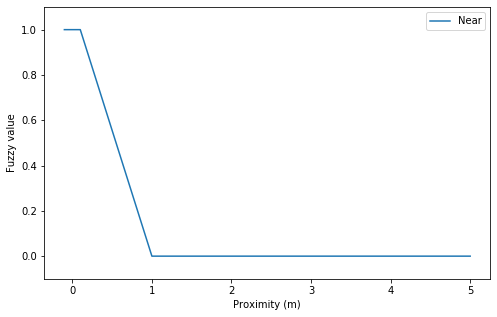

(array([1.        , 1.        , 1.        , 0.88888889, 0.77777778,
       0.66666667, 0.55555556, 0.44444444, 0.33333333, 0.22222222,
       0.11111111, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ]), array([-1]), array([-1]), array([-1]))


In [4]:
def sensor_fuzzyfication(frontal_sensors,_print=0) :
    x_v = np.arange(-0.1, 5.1, 0.1)
    t_close = [-0.1, -0.1, 0.1, 1]
    #t_far = [0.3, .55, 5, 5]
    mfx_close = fuzz.trapmf(x_v, t_close)
    #mfx_far = fuzz.trapmf(x_v, t_far)
    x_l = np.array([round(min(frontal_sensors[:2]))])
    x_f = np.array([min(frontal_sensors[3:5])])
    x_r = np.array([round(min(frontal_sensors[6:8]),1)])
    y_l = np.array([-1])
    y_f = np.array([-1])
    y_r = np.array([-1])
    if(x_l[0] < 1) :
        y_l = fuzz.trapmf(x_l, t_close)
    if(x_f[0] < 1) :
        y_f = fuzz.trapmf(x_f, t_close)
    if(x_r[0] < 1) :
        y_r = fuzz.trapmf(x_r, t_close)
    if (_print > 0) : 
        plt.figure(figsize=(8, 5))
        plt.plot(x_v, mfx_close,label="Near")
        colors = ['tab:black','tab:cyan','tab:purple','tab:green','tab:red','tab:brown','tab:olive','tab:gray','tab:pink']
        if(x_l[0] < 1) : plt.vlines(x_l, 0, y_l, label="min_left",color=colors[1]); print("Left sensors fuzzyfication: "+str(y_l[0]))
        if(x_f[0] < 1) : plt.vlines(x_f, 0, y_f, label="min_frontal",color=colors[2]); print("Forward sensors fuzzyfication: "+str(y_f[0]))
        if(x_r[0] < 1) : plt.vlines(x_r[0], 0, y_r, label="min_right",color=colors[3]); print("Right sensors fuzzyfication: "+str(y_r[0]))
        plt.ylabel('Fuzzy value')
        plt.xlabel('Proximity (m)')
        plt.ylim(-0.1, 1.1)
        plt.legend(loc=1)
        plt.show()
    return mfx_close, y_l, y_f, y_r
fuzzy = sensor_fuzzyfication(frontal,1)
print(fuzzy)

In [10]:
def avoidByDefuzzyfication(frontal_sensors,fuzzy_results, _print=0) :
    if (min(frontal_sensors) > 1) :
        velL = 2
        velR = 2
        return velL, velR
    y_v = np.arange(-95, 95, 1)
    x_v = np.arange(0, 5.1, 0.1)

    mfy_left = fuzz.trimf(y_v, [-95, -95,-10])
    mfy_foward = fuzz.trapmf(y_v, [-60,-30, 30,60])
    mfy_right = fuzz.trimf(y_v, [10,95,95])

    proximityL = ctrl.Antecedent(x_v, 'proximityL')
    proximityR = ctrl.Antecedent(x_v, 'proximityR')
    proximityF = ctrl.Antecedent(x_v, 'proximityF')
    velocity = ctrl.Consequent(y_v, 'Collision')

    proximity = fuzz.trapmf(x_v,[-0.1, -0.1, 0.1, 1])
    proximityL['near'] = proximity
    proximityR['near'] = proximity
    proximityF['near'] = proximity
    velocity['Left'] = mfy_left
    velocity['Forward'] = mfy_foward
    velocity['Right'] = mfy_right



    rule1 = ctrl.Rule(proximityL['near'] , velocity['Left'])
    rule2 = ctrl.Rule(proximityF['near'] , velocity['Forward'])
    rule3 = ctrl.Rule(proximityR['near'], velocity['Right'])

    vel_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
    vel = ctrl.ControlSystemSimulation(vel_ctrl)

    vel.input['proximityL'] = min(frontal_sensors[:3])
    vel.input['proximityR'] = min(frontal_sensors[5:8])
    vel.input['proximityF'] = min(frontal_sensors[2:6])

    if (_print > 0) :
        print("Distance Left: "+str(min(frontal[:2])))
        print("Distance Forward: "+str(min(frontal[3:5])))
        print("Distance Right: "+str(min(frontal[6:8])))

    vel_output = 1

    if (min(frontal_sensors) <= 1):
        vel.compute()
        
        vel_output = round(vel.output['Collision'])
        Collision = "Collision: "+str(vel_output)+"°"
    else: Collision = "No collision"
    if (_print > 0) :
        print(Collision)
        velocity.view(sim=vel)
    
    x_w = np.arange(-100,100,0.1)
    wlv = [-100, -100,0,50]
    wrv = [0,10,100,100]
    x = np.array([vel_output])
    y_l=fuzz.trapmf(x, wlv)
    y_r=fuzz.trapmf(x, wrv)
    if (_print > 0) :
        WheelL = fuzz.trapmf(x_w, wlv)
        WheelR = fuzz.trapmf(x_w, wrv)
        plt.figure(figsize=(8, 5))
        plt.plot(x_w, WheelL,label="Wheel Left")
        plt.plot(x_w, WheelR,label="Wheel Right")
        plt.vlines(x, 0, y_l, label="Collision")
        plt.vlines(x, 0, y_r)
        plt.legend()
        plt.show()
        print("Wheel left angular velocity: "+str((y_l[0]-0.5)/0.25))
        print("Wheel right angular velocity: "+str((y_r[0]-0.5)/0.25))
    
    velL = (y_l[0]-0.5)/0.25
    velR = (y_r[0]-0.5)/0.25

    return velL, velR
avoidByDefuzzyfication(frontal,fuzzy,1)

(2, 2)

In [ ]:
def wanderRobot() :
    while(robot.get_connection_status() != -1):
        us_distances = robot.read_ultrassonic_sensors()
        frontal = us_distances[:8] #Using only the 8 frontal sensors
        if (min(frontal) < 0.1) :
            robot.stop()
            return "Robô parou"
        else :
            fuzzy = sensor_fuzzyfication(frontal)
            avoid = avoidByDefuzzyfication(frontal,fuzzy)
            robot.set_left_velocity(avoid[0])
            robot.set_right_velocity(avoid[1])
        time.sleep(0.1)
wanderRobot()

In [9]:
robot.stop()